# Задача конкурса
Цель конкурса - предсказать количество мутности - уровень следов продукта или взвешенных твердых частиц в сточных водах - которые будут возвращаться на последнем этапе промывки во время очистки промышленного оборудования для производства продуктов питания и напитков. В зависимости от ожидаемого уровня мутности оператор станции очистки может соответствующим образом отрегулировать длительность финальной промывки, обеспечивая высокие стандарты очистки и минимизируя ненужное использование воды и химикатов.

Нам были предоставлены:
1. Обучающая выборка - данные о процессах очистки: 35 признаков, включая метаданные о процессе, фазе и объекте, а также данные временных рядов, которые получают через каждые 2 секунды. Измерения временных рядов относятся к мониторингу и контролю различных переменных процесса очистки в линиях подачи и возврата Clean-In-Place, а также в баках для чистящих материалов во время операций очистки. 
    Процесс очистки прохоит в несколько из фаз: 
    * этап предварительной промывки
    * фаза каустика
    * промежуточная фаза промывки
    * кислотная фаза
    * фаза финальной промывки
2. Целевой вектор - каждый процесс process_id в данных обучающих значений имеет соответствующую целевую переменную final_rinse_total_turbidity_liter в этом файле. final_rinse_total_turbidity_liter определяется как общее количество помутнения, возвращаемого в течение целевого периода времени, умноженного на выходящий поток во время финальной промывки, для каждого процесса очистки.(sum(max(0, return_flow) * return_turbidity) where target_time_period=True)
3. Контрольная выборка - временные ряды о процессах очистки без финала окончательной промыки.
4. Рецепт очистки - задается перед началом процесса очистки и определяет, через какие фазы будет проходить объект (1 - должен проходить, 0 - нет).
 
Необходимо для каждого процесса из контрольной выборки вычислить значение final_rinse_total_turbidity_liter. Также было отмечено, что в контрольной выборке могут отсутствовать некоторые фазы, но это не является отклонением от рецепта.

В отчете содержатся описания всех сделанных экспериментов, финальный метод и его аргументация.

In [25]:
import statistics
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [27]:
train_values = pd.read_csv('train_values.csv',
                           index_col=0,
                           parse_dates=['timestamp'])

train_labels = pd.read_csv('train_labels.csv',
                           index_col=0)

In [5]:
train_values.head()

,process_id,object_id,phase,timestamp,pipeline,supply_flow,supply_pressure,return_temperature,return_conductivity,return_turbidity,...,tank_temperature_pre_rinse,tank_temperature_caustic,tank_temperature_acid,tank_concentration_caustic,tank_concentration_acid,tank_lsh_caustic,tank_lsh_acid,tank_lsh_clean_water,tank_lsh_pre_rinse,target_time_period
row_id,,,,,,,,,,,,,,,,,,,,,
0,20001,405,pre_rinse,2018-04-15 04:20:47,L4,8550.348,0.615451,18.044704,4.990765,0.177228,...,32.385708,83.036750,73.03241,45.394646,44.340126,False,0.0,False,0.0,False
1,20001,405,pre_rinse,2018-04-15 04:20:49,L4,11364.294,0.654297,18.229168,3.749680,0.122975,...,32.385708,83.015045,73.03241,45.394447,44.339380,False,0.0,False,0.0,False
2,20001,405,pre_rinse,2018-04-15 04:20:51,L4,12174.479,0.699870,18.395544,2.783954,0.387008,...,32.385708,83.015045,73.03241,45.396280,44.336735,False,0.0,False,0.0,False
3,20001,405,pre_rinse,2018-04-15 04:20:53,L4,13436.776,0.761502,18.583622,1.769353,0.213397,...,32.385708,83.036750,73.03241,45.401875,44.333110,False,0.0,False,0.0,False
4,20001,405,pre_rinse,2018-04-15 04:20:55,L4,13776.766,0.837240,18.627026,0.904020,0.148293,...,32.385708,83.015045,73.03241,45.398197,44.334373,False,0.0,False,0.0,False


Чтобы лучше понять, как рассчитывается целевая переменная, надо изучить ее компоненты, return_turbidity и return_flow, за целевой период времени. Целевой период времени, когда мы хотим измерить мутность, обозначен логическим столбцом target_time_period. Это когда мы находимся в последнем полоскании и обратные клапаны едкого и обратного кислот были закрыты в последний раз. Убедимся в этом на примере процесса 20001:

In [28]:
target = train_values[train_values.process_id == 20001][train_values.target_time_period == True]
target = (np.maximum(target.return_flow, 0) * target.return_turbidity).sum()
print(target)
print(train_labels.loc[20001])

4318275.12554818
final_rinse_total_turbidity_liter    4.318275e+06
Name: 20001, dtype: float64


# Подход к решению задачи

Так как по каждому процессу нам даны временные ряды 35 признаков, а целевая переменная - число, то сразу приходят в голову несколько идей:
1. Понять зависимость return_turbidity и return_flow от остальных временных рядов, которые потом спрогнозировать и посчитать скалярное произведение return_turbidity и return_flow
2. Уменьшить размерность матрицы признаков для объекта от (n * m) до (1 * k), где  n, m, k - натуральные числа, и, тем самым, свести задачу к регрессии

Я остановлюсь на втором варианте. Далее я опишу различные идеи, которые проверяла, но не все из них были использованы в финальном решении.

Тестовый набор не включает каких-либо наблюдений на заключительном этапе промывки, так как цель состоит в том, чтобы предсказать окончательное помутнение достаточно рано, чтобы оператор станции очистки мог соответствующим образом отрегулировать продолжительность этой фазы. Чтобы гарантировать, что наша модель не зависит от наблюдений на последнем этапе, важно удалить эти наблюдения из наших данных обучения:

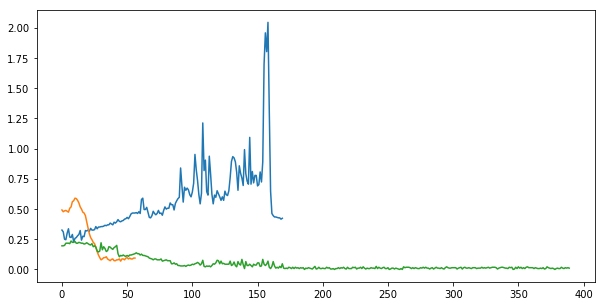

In [29]:
proc_1 = list(train_values[train_values.process_id == 20001][(train_values.target_time_period)]['return_turbidity'])
proc_2 = list(train_values[train_values.process_id == 20002][train_values.target_time_period==True]['return_turbidity'])
proc_3 = list(train_values[train_values.process_id == 20003][train_values.target_time_period==True]['return_turbidity'])

f = plt.figure(figsize = (10, 5))
plt.plot(list(range(np.size(proc_1))), proc_1)
plt.plot(list(range(np.size(proc_2))), proc_2)
plt.plot(list(range(np.size(proc_3))), proc_3)

In [8]:
train_values = train_values[train_values.phase != 'final_rinse']

Для начала я изучила данные на наличие признаков, которые на всех объектах принимают одно значение, а значит не несут никакой информации:

In [9]:
train_values.tank_lsh_pre_rinse.value_counts()

0.0    4475493
Name: tank_lsh_pre_rinse, dtype: int64

Они действительно есть, удалим их:

In [11]:
for feature in list(train_values):
    if train_values[feature].nunique() == 1:
        print(feature)
        del train_values[feature]

tank_lsh_acid
tank_lsh_pre_rinse
target_time_period


In [12]:
train_values.shape

(4475493, 32)

In [13]:
phases = train_values.phase.unique()

Далее удалим из обучающей таблицы процессы, которые не по рецепту (потому что в них может быть ошибка, которая нам не нужна при обучении):

In [14]:
recipe = pd.read_csv('recipe_metadata.csv', sep = ',')

In [15]:
print(train_values.process_id.nunique())
for id_ in train_values.process_id.unique():
    k_phases = train_values[train_values.process_id == id_].phase.unique()
    for phase in phases:
        if int(recipe[recipe.process_id == id_][phase]) != (phase in k_phases):
            train_values = train_values[train_values.process_id != id_]
            break

5005


In [16]:
train_values.shape

(4356747, 32)

In [17]:
train_values.process_id.nunique()

4738

Как видно, ошибка составила 5.3%

# Генерация признаков

Далее шла отдельная работа с разными видами признаков. Начнем с *числовых*, ниже приведен их список:

In [ ]:
ts_cols = [
    'process_id', #
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
]

Самый простой вариант - применить к этим столбцам функции 'min', 'max', 'mean', 'std' и среднее значение за последние 5 наблюдений, сгруппированные по процессу

In [ ]:
def prep_time_series_features(df):
    ts_df = df[ts_cols].set_index('process_id')
    ts_features = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', lambda x: x.tail(5).mean()])
    return ts_features

Далее я решила применять похожие функции не ко всему временному ряду для каждого признака, а поделить на фазы (+ из-за очень не линейного вида временные рядов была взята медиана и из вида графиков стало понятно, что можно добавить признак - среднее значение за 10 первых измерений):

In [ ]:
def prep_phases(df):
    ts_features = pd.DataFrame({'process_id' : df.process_id.unique()})
    ts_features = ts_features.set_index('process_id')
    df = df.set_index('process_id')

    for phase in phases:
        phase_min = df[df.phase == phase].groupby('process_id')[ts_cols].agg([(phase + '_min', 'min'),
                                                                              (phase + '_max', 'max'),
                                                                              (phase + '_std', 'std'),
                                                                              (phase + '_median', 'median'),
                                                                              (phase + '_tail', lambda x: x.tail(15).mean()), 
                                                                              (phase + '_head', lambda x: x.head(20).mean())])])
        ts_features = pd.concat([ts_features, phase_min], axis=1)
    supply_return = df[df.phase == phase].groupby('process_id')['supret'].agg([(phase + '_med', 'median')])
    ts_features = pd.concat([ts_features, supply_return], axis=1)
    return ts_features

Был добавлен новый признак - разность входного и выходного потока (с ним я тоже пробовала разные варианты - для каждого процесса считать среднее значение за все время, с разбиением на фазы, применяя 'min', 'max' и т.д. (как выше)):

In [ ]:
train_values = pd.concat([train_values, (train_values["supply_flow"] -  train_values["return_flow"])], axis=1)

In [ ]:
train_limited.rename(columns={0: 'supret'}, inplace=True)

Также я считала отклонение ('f1'), среднее значение ('f2') и среднее количество наблюдений, где приращение было положительно ('f3'):

In [ ]:
def prep_time_series_new(df):
    ts_df = df[ts_cols].set_index('process_id')
    ts_features = ts_df.groupby('process_id').agg([('f1', lambda x: x.diff().abs().std()), 
                                                  ('f2', lambda x: x.diff().abs().mean()),
                                                  ('f3', lambda clm: sum(x > 0 for x in clm.diff().values) / clm.size)])
    return ts_features


Т.к. иногда целевая переменная зависит от функции столбца сильнее, чем от самого столбца, то я решила попробовать признаки columns_sqr(считает квадраты значений чисел в столбце) и columns_sqrt (корни):

In [ ]:
import math

In [ ]:
def columns_sqr(df):
    return df.groupby('process_id').apply(lambda row: row * row)
def columns_sqrt(df):
    return df.groupby('process_id').agg(math.sqrt)

Еще можно было посчитать длину каждой фазы (т.к. измерения проводились каждые 2с, то длина фазы эквивалентна количеству чисел в любом соответствующем столбце, я взяла 'object_id'):

In [ ]:
def prep_time(df):
    ts_features = pd.DataFrame({'process_id' : df.index.unique()})
    ts_features = ts_features.set_index('process_id')
    for phase in process_phases:
        time_return = df[df.phase == phase].groupby('process_id')['object_id'].agg([(phase + '_time', lambda x: x.size)])
        ts_features = ts_features.join(time_return)
    return ts_features

Из-за того, что не все процессы проходили через все фазы, при генерации признаков погли возникнуть *пропуски*. Я пробовала заполнять их медианой и интерполировать полиномами разной степени (код ниже). Лучше оказалась медиана.

In [ ]:
df.fillna(df.median(), inplace=True)
#df = df.interpolate(method='polynomial', order=2)

Отдельный интерес представляли столбцы "object_id" и "pipeline". Их ограниченное количество. Каждый процесс работал только с одним объектом и трубой, но обратное неверно. Можно предположить, что для определенных объектов и труб свои сценарии очистки.

Эти признаки *категориальные*.

In [18]:
train_values[['process_id', 'object_id']].drop_duplicates().nunique()

process_id    4738
object_id       90
dtype: int64

In [19]:
train_values[['process_id', 'pipeline']].drop_duplicates().nunique()

process_id    4738
pipeline        11
dtype: int64

Я с ними работала двумя способами: Label Encoding и One-Hot-encoding.

С Label Encoding есть небольшая проблема — он присваивает числовые значения, которые не имеют ничего общего с реальностью.
One-Hot-encoding, с другой стороны, более безопасен, но может добавить «лишние» столбцы.
Объектов слишком много, чтобы использовать one-Hot-encoding, поэтому я сделала столбец их значений, с трубами я попробовала оба варианта:

In [ ]:
def prep_metadata(df):
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    meta = pd.get_dummies(meta)

    return meta.join(df[['process_id', 'object_id']].drop_duplicates().set_index("process_id"))

Оказалось, что 'pipeline_L12' содержит только нулевые значения, и нужно будет убрать еще какую-то из труб, потому что она будет излишней.

In [ ]:
from sklearn import preprocessing

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(train['pipeline'])

In [ ]:
def prep_meta(df):
    meta = df[['process_id', 'pipeline']].drop_duplicates().set_index('process_id') 
    meta["pipe"] = le.transform(meta)
    del meta['pipeline']
    return meta.join(df[['process_id', 'object_id']].drop_duplicates().set_index("process_id"))

Обработкой булевских значений я занималась немного, потому что признаков получилось и так много, но все же я попробовала некоторые вещи. 

In [ ]:
bool_features = [
'process_id',
'supply_pump',
 'supply_pre_rinse',
 'supply_caustic',
 'return_caustic',
 'supply_acid',
 'return_acid',
 'supply_clean_water',
 'return_recovery_water',
 'return_drain',
 'object_low_level']

Так я считала среднее значение количества открытия/закрытия клапана(можно считать это средней продолжительностью времени, так как данные снимаются каждые 2 секунды):

In [ ]:
bool_df = train_values[bool_phases].set_index('process_id')
bool_features = bool_df.groupby('process_id').agg([lambda x: (x.astype("int").sum()) / x.shape[0]])

In [ ]:
for i in train_values.process_id.unique():
    if train_values[train_values.process_id == i].tank_lsh_caustic.nunique() != 1:
        print(i)
        break

Интерес представляют парные признаки вида supply x - return x:

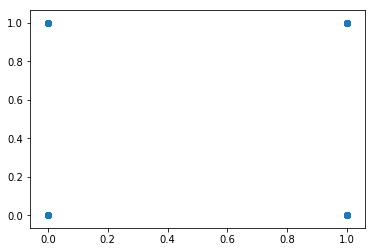

In [23]:
plt.scatter(train_values[train_values.process_id == 20003].supply_acid.values,\
            train_values[train_values.process_id == 20003].return_acid.values)

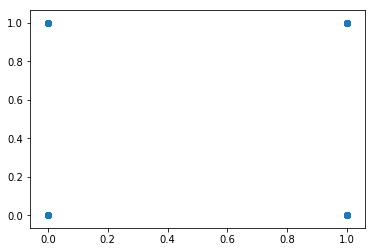

In [24]:
plt.scatter(train_values.supply_acid.values, train_values.return_acid.values)

Отсюда видно, что какие-то значения противоположны: когда supply клапан открыт, return закрыт и наоборот
Но есть признаки, где могут быть открыты оба клапана. Можно было бы для каждого признака ввести такие состояния числом (сделать категориальным признаком):

In [22]:
(train_values["supply_acid"].astype('int') + train_values["return_acid"].astype('int')).value_counts()

0    3224200
2     720850
1     411697
dtype: int64

Варианты получения матрицы признаков были разные, они комбинировали различные методы, описаные выше, например:

In [ ]:
def creat_mtx_time(df):
    train_prep_phases = prep_phases(df)
    train_prep_phases.fillna(train_prep_phases.median(), inplace=True)

    ts_features = prep_time_series_features(df)
    return ts_features.join(train_prep_phases, on='process_id')

In [ ]:
def cool_mtx(df):
    x = prep_time_series_new(df)
    feature_matrix = pd.merge(columns_sqr(x), columns_sqrt(x), on='process_id')
    feature_matrix = pd.concat([feature_matrix, x], axis = 1)

    time_series = prep_time_series_features(df)
    feature_matrix1 = pd.merge(columns_sqr(time_series), columns_sqrt(time_series), on='process_id')
    feature_matrix1 = pd.concat([feature_matrix1, time_series], axis = 1)

    feature_matrix = pd.concat([feature_matrix, feature_matrix1], axis = 1)

    return feature_matrix

В *финальном* решении матрицу признаков (feature_matrix) я получила следующим образом (признаки сформированы по фазам и пропуски заполнены медианой):

In [ ]:
def creat_mtx(df):
    prep_phases_mtx = prep_phases(df)
    prep_phases_mtx.fillna(prep_phases_mtx.median(), inplace=True)
    return prep_phases_mtx 

In [ ]:
feature_matrix = creat_mtx(train_values)
feature_matrix = feature_matrix.join(prep_meta(train_values))

# Отбор признаков

С увеличением количества фич часто падает точность предсказания.
Чтобы численно оценить степень влияния признаков я использовала коэффициент корреляции Пирсона. Достаточно оставить один из коллинеарных признаков, чтобы помочь алгоритму лучше обобщать и получать более интерпретируемые результаты на выходе.

Как видно, у нас появились линейно-зависимые признаки:

In [ ]:
f = plt.figure(figsize = (5, 5))
plt.scatter(feature_matrix["('supply_caustic', '<lambda>')"], feature_matrix["('return_caustic', '<lambda>')"])

<img src="images/supret_caustic.png">

In [ ]:
f = plt.figure(figsize = (10, 10))
plt.scatter(feature_matrix["('supply_acid', '<lambda>')"], feature_matrix["('return_acid', '<lambda>')"])

<img src="images/supret_acid.png">

In [ ]:
f = plt.figure(figsize = (10, 10))
plt.scatter(feature_matrix["('supply_flow', '<lambda>')"], feature_matrix["('return_flow', '<lambda>')"])

<img src="images/supret_flow.png">





Чтобы оценить, много ли таких признаков, посмотрим на тепловую карту матрицы корреляции

In [ ]:
corr = feature_matrix.corr()

In [ ]:
f, ax = plt.subplots(figsize=(40, 30))
hm = sns.heatmap(corr, ax = ax, cmap = "coolwarm", vmin = -0.25, annot = False, fmt = '.2f', linewidths=.08)

<img src="images/corr.png">

Одним из вариантов было убрать признаки, которые сильно коррелируют между собой, я выбрала порог 0.75, (их названия я добавляла в список "bad_features", чтобы потом убрать для тестовой матрицы):

In [ ]:
bad_features = []

In [ ]:
corr = feature_matrix.corr()
features = list(feature_matrix)
for k1 in range(len(features)):
    k2 = k1 + 1
    while k2 < len(features):
        if corr[features[k1]][features[k2]] > 0.75:
            bad_features.append(features[k1]) ######
            del feature_matrix[features[k1]]
            break
        k2 += 1

Также я смотрела корреляцию с целевой переменной:

In [2]:
import pandas as pd

In [5]:
labels = pd.read_csv("train_labels.csv")

In [ ]:
target_corr = labels.set_index("process_id").join(feature_matrix, how='right').corr()["final_rinse_total_turbidity_liter"]

In [ ]:
target_corr.sort_values()

# Анализ метрики

Одной из решающих для меня вещей в этом соревновании стал анализ метрики.

Нам предлагался вариант MAPE (mean absolute percentage error):
$$MAPE = \frac{1}{N} \sum_{i=1}^{N} \frac{|\hat{y_i} - y_i|}{max(|y_i|, \text{290000})}$$

Это среднее значение погрешности по всем элементам, сдвинутое на порог, чтобы не получить деления на 0.

Видно, что наибольшую погрешность дают маленькие значения (потому что делим на меньшее), поэтому я решила разделить выборку по своему порогу, чтобы обучиться отдельно. Для этого я посмотрела медиану и среднее значение "final_rinse_total_turbidity_liter". Т.к. медиана лучше подходит для среднего, то первоначально я взяла порог ближе к ней = 1.000.000.

In [6]:
labels["final_rinse_total_turbidity_liter"].median()

702483.3519640851

In [7]:
labels["final_rinse_total_turbidity_liter"].mean()

2140087.6936863856

Я отделила часть выборки (в матрице осталось 3034 строки):

In [ ]:
feature_matrix = feature_matrix[feature_matrix.final_rinse_total_turbidity_liter < 1000000]

In [ ]:
target = feature_matrix.join(labels.set_index("process_id"), how='left')['final_rinse_total_turbidity_liter'].values

Этот порог и некоторые из признаков я проверяла с помощью разбиения трейна (тогда дальше в регрессор подавались X_train и y_train):

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, target, 
        test_size=0.3, stratify=target)

Чтобы сравнивать результаты с помощью MAPE я его написала (criterion_):

In [ ]:
threshold = 290000
def criterion_(predict, target):
    return (np.absolute(predict - target) / np.maximum(np.absolute(predict), np.ones(predict.size).astype("int") * threshold)).sum(axis = 1) /\
            predict.size

# Построение модели

Я стала решать задачу с помощью случайного леса

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time
rf = RandomForestRegressor(n_estimators=1000, random_state=143)
rf.fit(feature_matrix, target)

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=df.columns)
feat_importances.nlargest(10).plot(kind='barh')

<img src="images/feat_importances.png">

# Оптимизация гиперпараметров модели

Я хотела подобрать параметры дерева с помощью GridSearchCV (но не успела)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
tree = RandomForestRegressor()

In [ ]:
tree_params = {'n_estimators': [300, 500, 800, 1000],
               'max_depth': [15, 20, 25, 30]
               'max_features': ["auto", "sqrt", "log2"], 
               'min_samples_leaf': [5, 10, 15]
               'bootstrap': [True, False]}

In [ ]:
tree_grid = GridSearchCV(tree, tree_params, n_jobs=-1, cv=5)

In [ ]:
tree_grid.fit(feature_matrix, labels)

In [ ]:
tree_grid.best_params_

# Проверка модели на тестoвой выборке

Тестовая выборка создавалась аналогичным образом:

In [ ]:
test = pd.read_csv("test_values.csv")
test = pd.concat([test, (test["supply_flow"] -  test["return_flow"])], axis=1)
test.rename(columns={0: 'supret'}, inplace=True)

In [ ]:
test_ = prep_metadata(test).join(creat_mtx(test))

Если по ходу решения я удаляла какие-то признаки из матрицы фичей, например, из-за высокой корреляции (но в финальном решении я оставила матрицу, как она была получена на этапе генерации признаков), то при предсказании на тесте я удаляла их из соответствующей тестовой матрицы:

In [ ]:
features = list(feature_matrix)
for k in list(test_matrix):
    if k not in features:
        del test_[k]

# Получение и сохранение результата

In [ ]:
res = rf.predict(test_)

In [ ]:
pd.DataFrame({'process_id': meta_test.index, 'final_rinse_total_turbidity_liter': res}).to_csv('submit.csv', index=False)

Также если бы у меня было еще время, то я бы поработала с  булевскими признаками, нашла бы какие-то еще показательные статистические свойства временных рядов. Еще была идея обучиться не только на значениях с целевой переменной < 1.000.000, но и на больших (потому что с таким ограничнием я обучалась примерно на 60% тренировочных данных), а потом скомбинировать предсказания от двух регрессоров, например, сложить решения с определенными коэффициентами, которые подобрать.

Можно было бы попробовать другую модель, например, xgboost. Только для нее нужно было оставить меньше признаков, например, те, которые определит случайный лес. Еще сложность состояла в том, что распределение фаз в тренировочном и тестовом наборе сильно различалось, можно было бы не обучаться на данных с одной фазой, потому что я заполняла пропуски по фазам, или придумать другой вариант заполнения.

In [ ]:
test.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()

<img src="images/phases.png">

In [ ]:
train_values.groupby('process_id').phase.nunique().value_counts().sort_index().plot.bar()

<img src="images/phases-train.png">

Итоговое место я точно сказать не могу, потому что итоговый сабмит (1 марта) был сделан в команде в надежде войти в топ (об этом писали), до этого мой лучший скор был 0.5217 (место около 80)

логин: poliik